# Propellant study
This program is used to help in setting design parameters for the engine (chamber pressure and O/F ratio) once propellants are chosen. NASA CEA (Chemical Equilibrium with Calculations) handles the thermodynamic calculations; this notebook just provides CEA with inputs and helps with plotting outputs.

CEA provides a number of output parameters (see ceadata.out for the direct program output), but this code only looks at a few of them: cstar, a measure of propellant performance, independent of the nozzle properties and operating conditions of the engine; and chamber_temp, which can't be too high or our engine will melt.

In [ ]:
#Calculations

In [47]:
from lib import cea
import numpy as np
from matplotlib import pyplot as plt

In [38]:
# specify problem
equilibrium = True
fuel = 'JP-5'
ox = 'O2'
propellant_initial_temp = 298
pchams = np.linspace(15, 40, 6)  # chamber pressures of interest
pamb = 1.013  # ambient pressure at exit
ofs = np.linspace(1.8, 2.8, num=20)  # oxidiser/fuel (mass) ratios of interest

In [61]:
#run calculations using CEA program from NASA. this code block is slow, but you can run it once and then mess with plots.
result_mat = []

for pcham in pchams:
    result_mat.append([])
    for of in ofs:
        inp = cea.CEAInputData()
        inp.equilibrium = equilibrium
        inp.fuel_chems = (fuel,)
        inp.fuel_chem_mass_percs = (100,)
        inp.fuel_initial_temp = propellant_initial_temp
        inp.ox_chem = ox
        inp.ox_initial_temp = propellant_initial_temp
        inp.pamb = pamb

        inp.pcham = pcham
        inp.of = of

        cea.create_inp_file(inp)
        cea.run_executable()
        out = cea.parse_out_file()

        result_mat[-1].append(out)

In [62]:
#post-processing of output
of_mat, pcham_mat = np.meshgrid(ofs, pchams)

def extract(matrix, extract_func):
    return np.array([[extract_func(elem) for elem in row] for row in matrix])

cstar_mat = extract(result_mat, lambda out: out.cstar)
temp_mat = extract(result_mat, lambda out: out.chamber_temp)

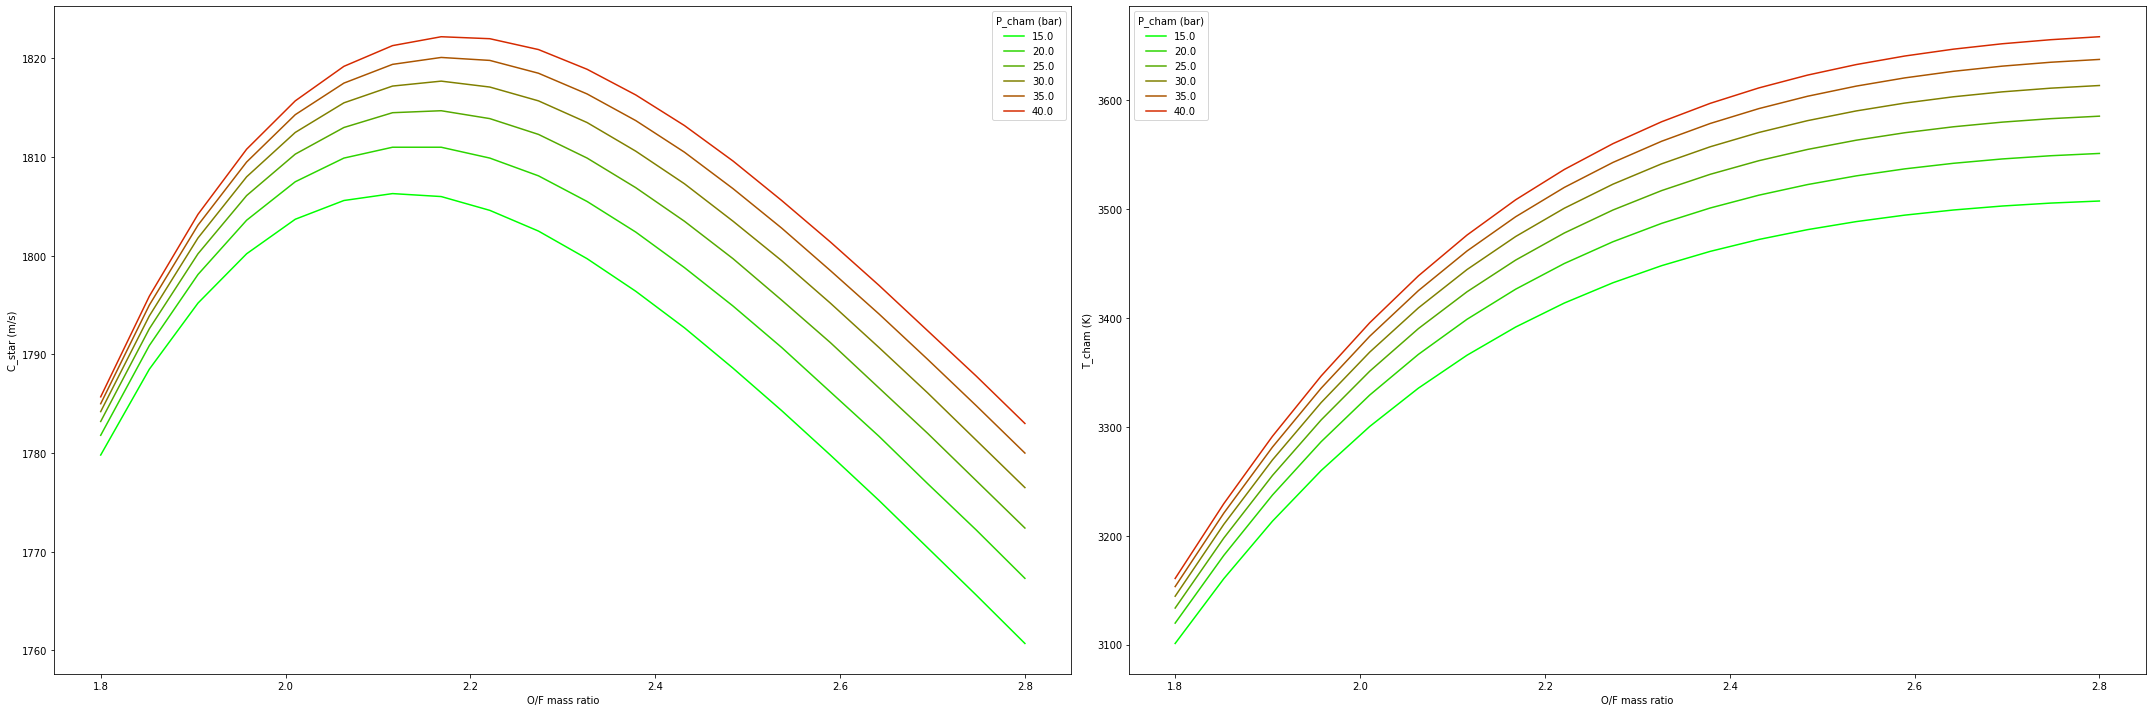

In [71]:
fig = plt.figure(figsize=[30,10])
axL = fig.add_subplot(121)
axR = fig.add_subplot(122)
axL.set_xlabel('O/F mass ratio')
axL.set_ylabel('C_star (m/s)')
axR.set_xlabel('O/F mass ratio')
axR.set_ylabel('T_cham (K)')
for i in range(len(pchams)):
    pcham = pchams[i]
    ofs = of_mat[i]
    cstars = cstar_mat[i]
    temps = temp_mat[i]
    frac = i/len(pchams)
    linecolor = (frac, 1 - frac, 0)
    axL.plot(ofs, cstars, color=linecolor, label=f'{pchams[i]:.1f}')
    axR.plot(ofs, temps, color=linecolor, label=f'{pchams[i]:.1f}')
axL.legend(title='P_cham (bar)')
axR.legend(title='P_cham (bar)')
fig.tight_layout()  # stops margin overlap

Text(0.5, 0, 'Isp (sec)')

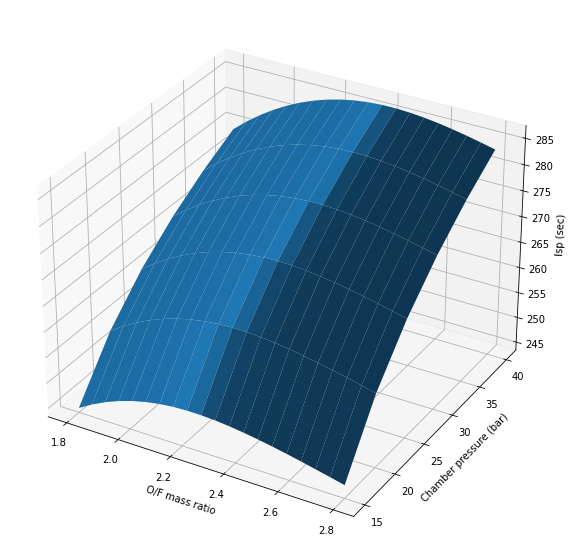

In [75]:
#Isp plot

%matplotlib inline
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(of_mat, pcham_mat, isp_mat)
ax.set_xlabel('O/F mass ratio')
ax.set_ylabel('Chamber pressure (bar)')
ax.set_zlabel('Isp (sec)')

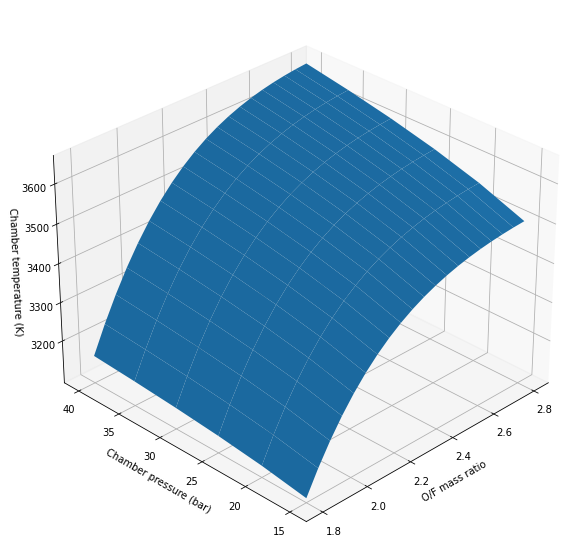

In [76]:
#Tcham plot

%matplotlib inline
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(of_mat, pcham_mat, temp_mat)
ax.set_xlabel('O/F mass ratio')
ax.set_ylabel('Chamber pressure (bar)')
ax.set_zlabel('Chamber temperature (K)')
ax.view_init(azim=225)